In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import h5py
import logging
from os import path
from pandas import HDFStore
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import pathlib
import shutil
import tempfile
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from tensorflow.keras import layers
from tensorflow.keras import regularizers



%matplotlib inline

In [2]:
#!pip install -q git+https://github.com/tensorflow/docs

In [2]:
logdir = pathlib.Path("C:/tmp/")/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=False)

In [3]:
#Load data from hdf5 file
root_path = "Z:/elekin"
rdo_root_path = path.join(root_path,"02-RESULTADOS/03-HANDWRITTING")
h5file = path.join(rdo_root_path, "00-OUTPUT/archimedean-")
h5filename = h5file + str(17) + ".h5"
hdf = HDFStore(h5filename)

In [4]:
#Load and scale timeseries between 0 and 1
raw_df = hdf['results/residues/rd'].T
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = pd.DataFrame(scaler.fit_transform(raw_df))
scaled_df['target'] = hdf.get('source/labels').values

In [5]:
# split data into train and test datasets (0.8, 0.2)
shuffle_df = scaled_df.sample(frac=1).reset_index(drop=True)
msk = np.random.rand(len(shuffle_df)) < 0.8
x_train = shuffle_df[msk].iloc[:,0:4096].values.astype('float32')
y_train = shuffle_df[msk]['target'].values.astype('int8')
x_test = shuffle_df[~msk].iloc[:,0:4096].values.astype('float32')
y_test = shuffle_df[~msk]['target'].values.astype('int8')

In [7]:
x_train.shape, y_train.shape

((44, 4096), (44,))

In [6]:
#Early stop configuration
earlystop_callback = EarlyStopping(
  monitor='val_accuracy', min_delta=0.0001,
  patience=20)

training_earlystop_callback = EarlyStopping(
  monitor='accuracy', min_delta=0.0001,
  patience=5)

def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
        tf.keras.callbacks.TensorBoard(logdir/name),
      ]

def compile_and_fit(model, name, optimizer=None, max_epochs=1000):
    if optimizer is None:
        optimizer = get_optimizer()
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'binary_crossentropy'])
        model.summary()
        history = model.fit(x_train, y_train, batch_size=None, use_multiprocessing=True, 
                            validation_data=(x_test,y_test), epochs=max_epochs, callbacks=get_callbacks(name),
                            verbose=0)
        return history

In [7]:
tf.random.set_seed(2019) # establecemos la semilla para tensorflow
np.random.seed(2019) # establecemos la semilla para numpy

## OVERFITING ANALISYS

Many models train better if you gradually reduce the learning rate during training. 
Use optimizers.schedules to reduce the learning rate over time:

In [8]:
STEPS_PER_EPOCH = 1
FEATURES = 4096

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

In [37]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
tiny = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(FEATURES,)),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

In [38]:
size_histories = {}

In [39]:
size_histories['fcnn/tiny'] = compile_and_fit(tiny, "fcnn/tiny", optimizer=None, max_epochs=1000)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                65552     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 65,569
Trainable params: 65,569
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4865,  binary_crossentropy:0.9863,  loss:0.9863,  val_accuracy:0.5385,  val_binary_crossentropy:0.8049,  val_loss:0.8049,  
....................................................................................................
Epoch: 100, accuracy:0.5405,  binary_crossentropy:0.6921,  loss:0.6921,  val_accuracy:0.5385,  val_binary_crossentropy:0.6922,  val_loss:0.6922,  
....................................................................................................
Epoch: 200, accurac

In [40]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    tf.keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(FEATURES,)),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
size_histories['fcnn/small'] = compile_and_fit(small_model, 'fcnn/small')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                65552     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 65,841
Trainable params: 65,841
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5946,  binary_crossentropy:0.7247,  loss:0.7247,  val_accuracy:0.4615,  val_binary_crossentropy:0.7696,  val_loss:0.7696,  
....................................................................................................
Epoch: 100, accuracy:0.6757,  binary_crossentropy:0.6723,  loss:0.6723,  val_accuracy:0.6154,  val_binary_crossentropy:0.6672,  val_los

In [41]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
large_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation=tf.nn.relu, input_shape=(FEATURES,)),    
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
size_histories['fcnn/large'] = compile_and_fit(large_model, "fcnn/large")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               2097664   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 2,886,145
Trainable params: 2,886,145
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5405,  binary_crossentropy:1.3381,  loss:1.3381,  val_accuracy:0.5385,  val_binary_crossen

(0.4, 0.8)

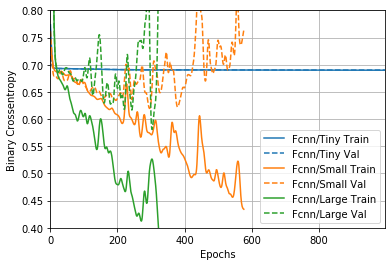

In [47]:
plotter_loss = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter_loss.plot(size_histories)
plt.ylim([0.4, 0.8])

(0.5, 0.9)

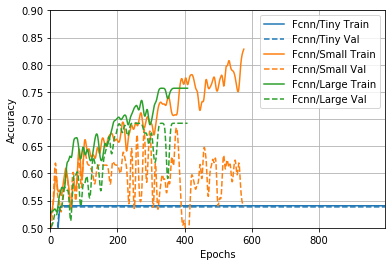

In [48]:
plotter_acc = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter_acc.plot(size_histories)
plt.ylim([0.5, 0.9])

Text(0.5, 0, 'Epochs [Log Scale]')

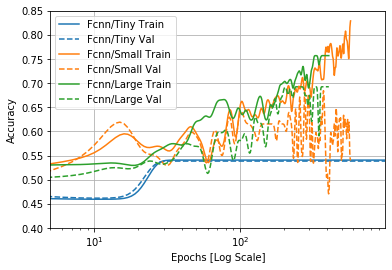

In [51]:
plotter_acc.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.4, 0.85])
plt.xlabel("Epochs [Log Scale]")

Text(0.5, 0, 'Epochs [Log Scale]')

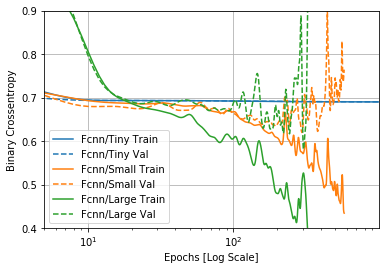

In [53]:
plotter_loss.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.4, 0.9])
plt.xlabel("Epochs [Log Scale]")

### Tensorboard

In [56]:
shutil.rmtree(logdir/'regularizers/tiny', ignore_errors=True)
shutil.copytree(logdir/'fcnn/tiny', logdir/'regularizers/tiny')
regularizer_histories = {}
regularizer_histories['tiny'] = size_histories['fcnn/tiny']

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights. one reason why L2 is more common.

In tf.keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.

In [107]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1, activation=tf.nn.sigmoid)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               2097664   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 2,886,145
Trainable params: 2,886,145
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5405,  binary_crossentropy:0.7461,  loss:3.1827,  val_accuracy:0.4615,  val_binary_crossen

(0.6, 0.9)

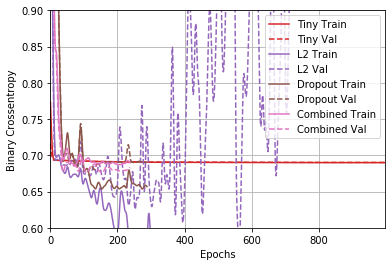

In [108]:
plotter_loss.plot(regularizer_histories)
plt.ylim([0.6, 0.9])

(0.1, 0.9)

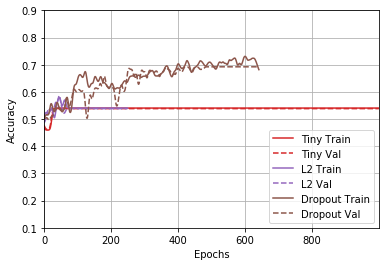

In [75]:
plotter_acc.plot(regularizer_histories)
plt.ylim([0.1, 0.9])

In [106]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
drop_model = tf.keras.Sequential([
    layers.Dense(512, activation=tf.nn.relu,
                 input_shape=(FEATURES,)),
    layers.Dropout(0.2),
    layers.Dense(512, activation=tf.nn.relu),
    layers.Dropout(0.2),
    layers.Dense(512, activation=tf.nn.relu),
    layers.Dropout(0.2),
    layers.Dense(512, activation=tf.nn.relu),
    layers.Dropout(0.2),
    layers.Dense(1, activation=tf.nn.sigmoid)
])

regularizer_histories['dropout'] = compile_and_fit(drop_model, "regularizers/dropout")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               2097664   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               2

In [119]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
combined_model = tf.keras.Sequential([
    layers.Dense(512, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(0.0001),
                 input_shape=(FEATURES,)),
    layers.Dropout(0.3),
    layers.Dense(512, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.3),
    layers.Dense(512, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.3),
    layers.Dense(512, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.3),
    layers.Dense(1, activation=tf.nn.sigmoid)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               2097664   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               2

(5, 999.0)

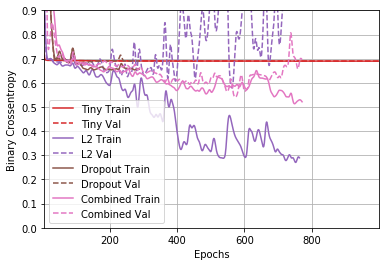

In [120]:
plotter_loss.plot(regularizer_histories)
plt.ylim([0., 0.9])
plt.xlim([5, max(plt.xlim())])

(0.4, 1.2)

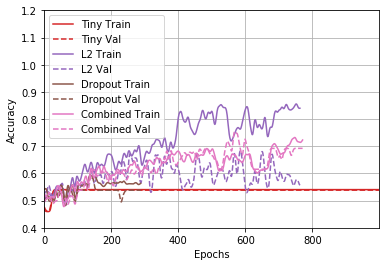

In [121]:
plotter_acc.plot(regularizer_histories)
plt.ylim([0.4, 1.2])